## Airline Passenger Volume

This model predicts the volume of airline passengers using historical data from January 1949 to December 1960, with a total of 144 observations. Even with this modest data set, surprisingly accurate predictions are possible.

This is time series data, which is well suited to Long-Short Term Memory ([LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# A convenience function to generate the current (X) and next (Y) sequence of data
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Training Data

The data is collected monthly, in units of 1000s of international passengers. The number of passengers expectedly increases with time. The data also appears cyclical, maybe due to holiday travel. LSTMs are capable of learning both features.

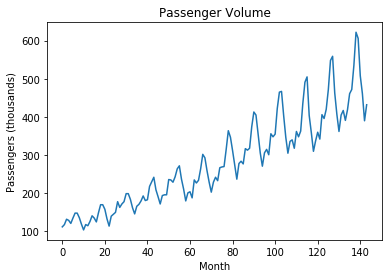

In [3]:
dataframe = pd.read_csv('data/airline-passengers.csv', usecols=[1], engine='python')
raw_data = dataframe.values.astype('float32')

plt.plot(raw_data)
plt.title('Passenger Volume')
plt.ylabel('Passengers (thousands)')
plt.xlabel('Month')
plt.show()

## Data Preparation

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(raw_data)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Train Model

A simple, but effective model.

In [5]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=40, batch_size=1, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Model Loss

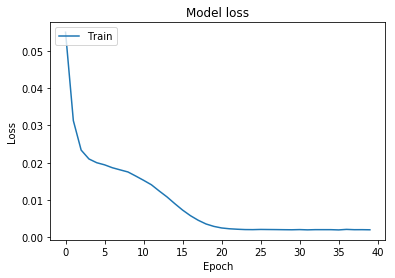

Minimum loss: 0.002


In [6]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()
print("Minimum loss: %.3f" % history.history['loss'][-1])

## Prediction

In [7]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
invTrainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
invTestY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(invTrainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(invTestY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.90 RMSE
Test Score: 48.38 RMSE


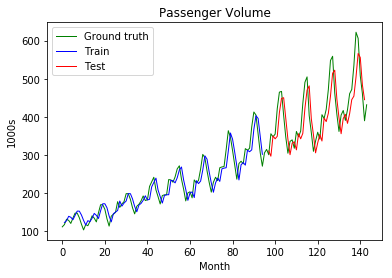

In [8]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot ground truth and predictions
plt.plot(scaler.inverse_transform(dataset), color='green', linewidth=1.0)
plt.plot(trainPredictPlot, color='blue', linewidth=1.0)
plt.plot(testPredictPlot, color='red', linewidth=1.0)
plt.title('Passenger Volume')
plt.ylabel('1000s')
plt.xlabel('Month')
plt.legend(['Ground truth', 'Train', 'Test'], loc='upper left')
plt.show()